# Make the in-sample data and out-of-sample data

We assume that all previous data is in-sample data , based on which out-of-sample data is generated .

In [3]:
# import libraries
import pandas as pd
import numpy as np
import os
import datetime

df = pd.read_csv('../data/processed/VNINDEX_add_features.csv')
df.head()

,DTYYYYMMDD,Ticker,Open,High,Low,Close,Volume,Outlier,daily_returns,monthly_returns,...,MA10,EMA10,MA20,EMA20,MA50,EMA50,MA100,EMA100,MA200,EMA200
0,2000-07-28,VNINDEX,100.000,100.000,100.000,100.000,4200.0,False,0.015500,0.1239,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2000-07-31,VNINDEX,101.550,101.550,101.550,101.550,10300.0,False,0.015500,0.1239,...,100.775000,100.281818,100.775000,100.147619,100.775000,100.060784,100.775000,100.030693,100.775000,100.015423
2,2000-08-01,VNINDEX,102.465,102.465,102.465,102.465,5300.0,False,0.009010,0.1239,...,101.338333,100.678760,101.338333,100.368322,101.338333,100.155067,101.338333,100.078897,101.338333,100.039797
3,2000-08-02,VNINDEX,103.380,103.380,103.380,103.380,300.0,False,0.008930,0.1239,...,101.848750,101.169895,101.848750,100.655148,101.848750,100.281535,101.848750,100.144266,101.848750,100.073033
4,2000-08-03,VNINDEX,104.290,104.290,104.290,104.290,2000.0,False,0.008802,0.1239,...,102.337000,101.737187,102.337000,101.001325,102.337000,100.438730,102.337000,100.226359,102.337000,100.114993


In [4]:
# Get the data of every year
yearly_data = {}
df['DTYYYYMMDD'] = pd.to_datetime(df['DTYYYYMMDD'])
years = df['DTYYYYMMDD'].dt.year.unique()
for year in years:
    yearly_data[year] = df[df['DTYYYYMMDD'].dt.year == year]
print(yearly_data[2024])

     DTYYYYMMDD   Ticker     Open     High      Low     Close        Volume  \
6111 2024-01-01  VNINDEX  1134.07  1137.38  1129.31  1130.825  6.995843e+08   
6112 2024-01-02  VNINDEX  1136.39  1139.71  1128.69  1131.720  7.780927e+08   
6113 2024-01-03  VNINDEX  1130.53  1144.17  1128.32  1144.170  6.575681e+08   
6114 2024-01-04  VNINDEX  1145.49  1160.08  1144.32  1150.720  1.141647e+09   
6115 2024-01-05  VNINDEX  1152.37  1155.84  1149.08  1154.680  7.602683e+08   
...         ...      ...      ...      ...      ...       ...           ...   
6368 2024-12-25  VNINDEX  1262.03  1283.09  1261.87  1274.040  7.243457e+08   
6369 2024-12-26  VNINDEX  1275.68  1277.17  1271.99  1272.870  5.020719e+08   
6370 2024-12-27  VNINDEX  1275.56  1277.89  1272.23  1275.140  5.798830e+08   
6371 2024-12-30  VNINDEX  1273.75  1274.15  1268.77  1272.020  4.529470e+08   
6372 2024-12-31  VNINDEX  1272.25  1272.46  1266.78  1266.780  4.071718e+08   

      Outlier  daily_returns  monthly_returns  ... 

In [ ]:
# Make the out-of-sample data for every year 
def make_out_of_sample_data(df):
    # Make the out-of-sample data for every year 
    # df is the data of that year
    out_of_sample_data = df.copy()
    year = out_of_sample_data['DTYYYYMMDD'].dt.year.unique()[0]
    dates = out_of_sample_data['DTYYYYMMDD'][1:out_of_sample_data['DTYYYYMMDD'].size-1]
    last_day_Close_price = out_of_sample_data['Close'].iloc[-1]
    daily_returns = out_of_sample_data['daily_returns']
    
    for i in range(1, len(dates)):
        current_date = dates.iloc[i]
        prev_date = dates.iloc[i-1]
        
        if current_date < pd.Timestamp(f'{year}-12-15'):
            out_of_sample_data.loc[out_of_sample_data['DTYYYYMMDD'] == current_date, 'Close'] = out_of_sample_data.loc[out_of_sample_data['DTYYYYMMDD'] == prev_date, 'Close'].iloc[0] * (1 + daily_returns.sample(1).iloc[0])
        else:
            if last_day_Close_price > out_of_sample_data.loc[out_of_sample_data['DTYYYYMMDD'] == prev_date, 'Close'].iloc[0]:
                out_of_sample_data.loc[out_of_sample_data['DTYYYYMMDD'] == current_date, 'Close'] = out_of_sample_data.loc[out_of_sample_data['DTYYYYMMDD'] == prev_date, 'Close'].iloc[0] * (1 + abs(daily_returns.sample(1).iloc[0]))
            else:
                out_of_sample_data.loc[out_of_sample_data['DTYYYYMMDD'] == current_date, 'Close'] = out_of_sample_data.loc[out_of_sample_data['DTYYYYMMDD'] == prev_date, 'Close'].iloc[0] * (1 - abs(daily_returns.sample(1).iloc[0]))
    return out_of_sample_data
def get_10_best_out_of_sample_data(df):
    # Filter the 10 best out-of-sample data from 100 out-of-sample data by calculating the correlation between the out-of-sample data and the in-sample data
    # df is the data of that year
    pair_data = []
    for i in range(100):
        out_of_sample_data = make_out_of_sample_data(df)
        corr = out_of_sample_data['Close'].corr(df['Close'])
        pair_data.append((abs(corr), out_of_sample_data))
    pair_data.sort(key=lambda x: x[0], reverse=True)
    result = [pair[1] for pair in pair_data[:10]]
    return result
for a in range(0,10):
    out_of_sample_data = {}
    for year in years:
        best_out_of_sample_data = get_10_best_out_of_sample_data(yearly_data[year])
        out_of_sample_data[year] = best_out_of_sample_data

    # Save the out-of-sample data to csv files
    for i in range(10):
        out_of_sample = []
        for year in years:
            out_of_sample.append(out_of_sample_data[year][i])
        out_of_sample = pd.concat(out_of_sample, ignore_index=True)
        out_of_sample.to_csv(f'../data/processed/out_of_sample_{i+1+a*10}.csv', index=False)

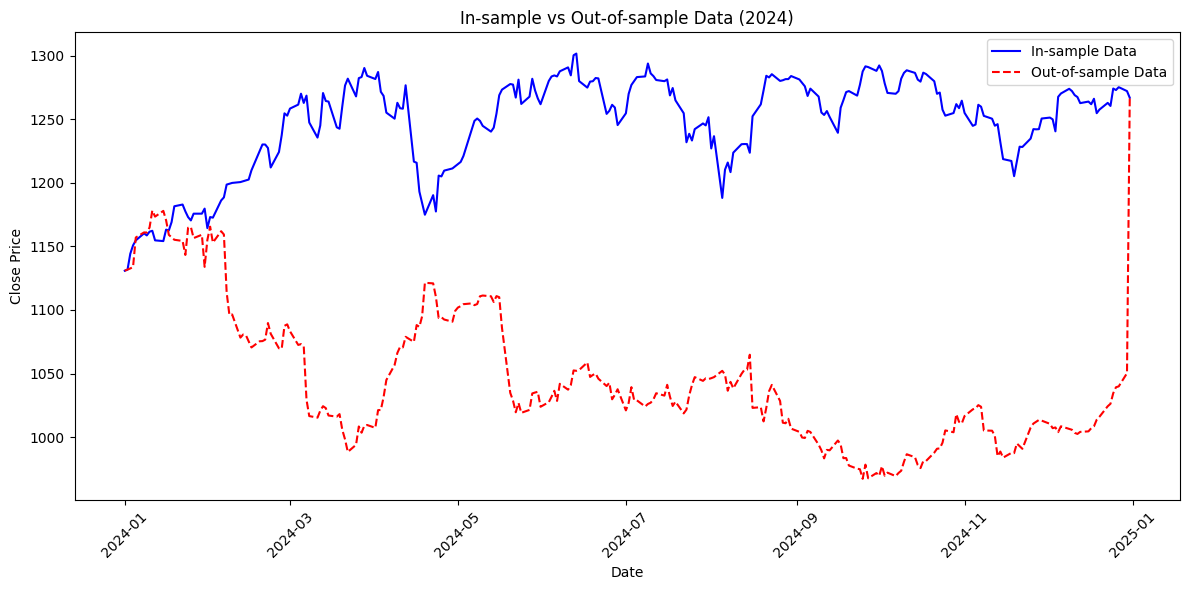

In [5]:
# Visualize the out-of-sample data and in-sample data
import matplotlib.pyplot as plt

# Create a single plot
plt.figure(figsize=(12, 6))

# Plot both in-sample and out-of-sample data
plt.plot(yearly_data[2024]['DTYYYYMMDD'], yearly_data[2024]['Close'], label='In-sample Data', color='blue')
plt.plot(out_of_sample_data[2024][0]['DTYYYYMMDD'], out_of_sample_data[2024][0]['Close'], label='Out-of-sample Data', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('In-sample vs Out-of-sample Data (2024)')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()